In [1]:
%matplotlib inline



# Receptive Field Estimation and Prediction

This example reproduces figures from Lalor et al.'s mTRF toolbox in
MATLAB :footcite:`CrosseEtAl2016`. We will show how the
:class:`mne.decoding.ReceptiveField` class
can perform a similar function along with scikit-learn. We will first fit a
linear encoding model using the continuously-varying speech envelope to predict
activity of a 128 channel EEG system. Then, we will take the reverse approach
and try to predict the speech envelope from the EEG (known in the literature
as a decoding model, or simply stimulus reconstruction).



In [2]:
# Authors: Chris Holdgraf <choldgraf@gmail.com>
#          Eric Larson <larson.eric.d@gmail.com>
#          Nicolas Barascud <nicolas.barascud@ens.fr>
#
# License: BSD (3-clause)

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from os.path import join

import mne
from mne.decoding import ReceptiveField
from sklearn.model_selection import KFold
from sklearn.preprocessing import scale

## Load the data from the publication

First we will load the data collected in :footcite:`CrosseEtAl2016`.
In this experiment subjects
listened to natural speech. Raw EEG and the speech stimulus are provided.
We will load these below, downsampling the data in order to speed up
computation since we know that our features are primarily low-frequency in
nature. Then we'll visualize both the EEG and speech envelope.



Creating RawArray with float64 data, n_channels=128, n_times=7677
    Range : 0 ... 7676 =      0.000 ...   119.938 secs
Ready.


[Text(0.5, 1.0, 'Sample activity'), Text(0.5, 0, 'Time (s)')]

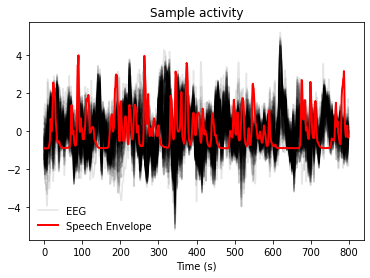

In [3]:
path = mne.datasets.mtrf.data_path()
decim = 2
data = loadmat(join(path, 'speech_data.mat'))
raw = data['EEG'].T
speech = data['envelope'].T
sfreq = float(data['Fs'])
sfreq /= decim
speech = mne.filter.resample(speech, down=decim, npad='auto')
raw = mne.filter.resample(raw, down=decim, npad='auto')

# Read in channel positions and create our MNE objects from the raw data
montage = mne.channels.make_standard_montage('biosemi128')
info = mne.create_info(montage.ch_names, sfreq, 'eeg').set_montage(montage)
raw = mne.io.RawArray(raw, info)
n_channels = len(raw.ch_names)

# Plot a sample of brain and stimulus activity
fig, ax = plt.subplots()
lns = ax.plot(scale(raw[:, :800][0].T), color='k', alpha=.1)
ln1 = ax.plot(scale(speech[0, :800]), color='r', lw=2)
ax.legend([lns[0], ln1[0]], ['EEG', 'Speech Envelope'], frameon=False)
ax.set(title="Sample activity", xlabel="Time (s)")
#mne.viz.tight_layout()

## Create and fit a receptive field model

We will construct an encoding model to find the linear relationship between
a time-delayed version of the speech envelope and the EEG signal. This allows
us to make predictions about the response to new stimuli.



split 1 / 3
Fitting 1 epochs, 1 channels


100%|██████████| Sample : 2/2 [00:00<00:00,    8.68it/s]

split 2 / 3
Fitting 1 epochs, 1 channels



100%|██████████| Sample : 2/2 [00:00<00:00,   59.25it/s]

split 3 / 3
Fitting 1 epochs, 1 channels



100%|██████████| Sample : 2/2 [00:00<00:00,   56.66it/s]


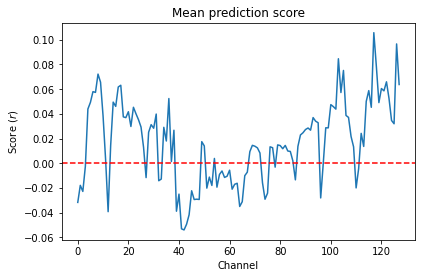

In [4]:
# Define the delays that we will use in the receptive field
tmin, tmax = -.2, .4

# Initialize the model
rf = ReceptiveField(tmin, tmax, sfreq, feature_names=['envelope'],
                    estimator=1., scoring='corrcoef')
# We'll have (tmax - tmin) * sfreq delays
# and an extra 2 delays since we are inclusive on the beginning / end index
n_delays = int((tmax - tmin) * sfreq) + 2

n_splits = 3
cv = KFold(n_splits)

# Prepare model data (make time the first dimension)
speech = speech.T
Y, _ = raw[:]  # Outputs for the model
Y = Y.T

# Iterate through splits, fit the model, and predict/test on held-out data
coefs = np.zeros((n_splits, n_channels, n_delays))
scores = np.zeros((n_splits, n_channels))
for ii, (train, test) in enumerate(cv.split(speech)):
    print('split %s / %s' % (ii + 1, n_splits))
    rf.fit(speech[train], Y[train])
    scores[ii] = rf.score(speech[test], Y[test])
    # coef_ is shape (n_outputs, n_features, n_delays). we only have 1 feature
    coefs[ii] = rf.coef_[:, 0, :]
times = rf.delays_ / float(rf.sfreq)

# Average scores and coefficients across CV splits
mean_coefs = coefs.mean(axis=0)
mean_scores = scores.mean(axis=0)

# Plot mean prediction scores across all channels
fig, ax = plt.subplots()
ix_chs = np.arange(n_channels)
ax.plot(ix_chs, mean_scores)
ax.axhline(0, ls='--', color='r')
ax.set(title="Mean prediction score", xlabel="Channel", ylabel="Score ($r$)")
mne.viz.tight_layout()

### Investigate model coefficients
Finally, we will look at how the linear coefficients (sometimes
referred to as beta values) are distributed across time delays as well as
across the scalp. We will recreate `figure 1`_ and `figure 2`_ from
:footcite:`CrosseEtAl2016`.



In [5]:
# Print mean coefficients across all time delays / channels (see Fig 1)
time_plot = 0.180  # For highlighting a specific time.
fig, ax = plt.subplots(figsize=(4, 8))
max_coef = mean_coefs.max()
ax.pcolormesh(times, ix_chs, mean_coefs, cmap='RdBu_r',
              vmin=-max_coef, vmax=max_coef, shading='gouraud')
ax.axvline(time_plot, ls='--', color='k', lw=2)
ax.set(xlabel='Delay (s)', ylabel='Channel', title="Mean Model\nCoefficients",
       xlim=times[[0, -1]], ylim=[len(ix_chs) - 1, 0],
       xticks=np.arange(tmin, tmax + .2, .2))
plt.setp(ax.get_xticklabels(), rotation=45)
mne.viz.tight_layout()

# Make a topographic map of coefficients for a given delay (see Fig 2C)
ix_plot = np.argmin(np.abs(time_plot - times))
fig, ax = plt.subplots()
mne.viz.plot_topomap(mean_coefs[:, ix_plot], pos=info, axes=ax, show=False,
                     vmin=-max_coef, vmax=max_coef)
ax.set(title="Topomap of model coefficients\nfor delay %s" % time_plot)
mne.viz.tight_layout()

## Create and fit a stimulus reconstruction model

We will now demonstrate another use case for the for the
:class:`mne.decoding.ReceptiveField` class as we try to predict the stimulus
activity from the EEG data. This is known in the literature as a decoding, or
stimulus reconstruction model :footcite:`CrosseEtAl2016`.
A decoding model aims to find the
relationship between the speech signal and a time-delayed version of the EEG.
This can be useful as we exploit all of the available neural data in a
multivariate context, compared to the encoding case which treats each M/EEG
channel as an independent feature. Therefore, decoding models might provide a
better quality of fit (at the expense of not controlling for stimulus
covariance), especially for low SNR stimuli such as speech.



In [ ]:
# We use the same lags as in :footcite:`CrosseEtAl2016`. Negative lags now
# index the relationship
# between the neural response and the speech envelope earlier in time, whereas
# positive lags would index how a unit change in the amplitude of the EEG would
# affect later stimulus activity (obviously this should have an amplitude of
# zero).
tmin, tmax = -.2, 0.

# Initialize the model. Here the features are the EEG data. We also specify
# ``patterns=True`` to compute inverse-transformed coefficients during model
# fitting (cf. next section and :footcite:`HaufeEtAl2014`).
# We'll use a ridge regression estimator with an alpha value similar to
# Crosse et al.
sr = ReceptiveField(tmin, tmax, sfreq, feature_names=raw.ch_names,
                    estimator=1e4, scoring='corrcoef', patterns=True)
# We'll have (tmax - tmin) * sfreq delays
# and an extra 2 delays since we are inclusive on the beginning / end index
n_delays = int((tmax - tmin) * sfreq) + 2

n_splits = 3
cv = KFold(n_splits)

# Iterate through splits, fit the model, and predict/test on held-out data
coefs = np.zeros((n_splits, n_channels, n_delays))
patterns = coefs.copy()
scores = np.zeros((n_splits,))
for ii, (train, test) in enumerate(cv.split(speech)):
    print('split %s / %s' % (ii + 1, n_splits))
    sr.fit(Y[train], speech[train])
    scores[ii] = sr.score(Y[test], speech[test])[0]
    # coef_ is shape (n_outputs, n_features, n_delays). We have 128 features
    coefs[ii] = sr.coef_[0, :, :]
    patterns[ii] = sr.patterns_[0, :, :]
times = sr.delays_ / float(sr.sfreq)

# Average scores and coefficients across CV splits
mean_coefs = coefs.mean(axis=0)
mean_patterns = patterns.mean(axis=0)
mean_scores = scores.mean(axis=0)
max_coef = np.abs(mean_coefs).max()
max_patterns = np.abs(mean_patterns).max()

### Visualize stimulus reconstruction

To get a sense of our model performance, we can plot the actual and predicted
stimulus envelopes side by side.



In [ ]:
y_pred = sr.predict(Y[test])
time = np.linspace(0, 2., 5 * int(sfreq))
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(time, speech[test][sr.valid_samples_][:int(5 * sfreq)],
        color='grey', lw=2, ls='--')
ax.plot(time, y_pred[sr.valid_samples_][:int(5 * sfreq)], color='r', lw=2)
ax.legend([lns[0], ln1[0]], ['Envelope', 'Reconstruction'], frameon=False)
ax.set(title="Stimulus reconstruction")
ax.set_xlabel('Time (s)')
mne.viz.tight_layout()

### Investigate model coefficients

Finally, we will look at how the decoding model coefficients are distributed
across the scalp. We will attempt to recreate `figure 5`_ from
:footcite:`CrosseEtAl2016`. The
decoding model weights reflect the channels that contribute most toward
reconstructing the stimulus signal, but are not directly interpretable in a
neurophysiological sense. Here we also look at the coefficients obtained
via an inversion procedure :footcite:`HaufeEtAl2014`, which have a more
straightforward
interpretation as their value (and sign) directly relates to the stimulus
signal's strength (and effect direction).



In [ ]:
time_plot = (-.140, -.125)  # To average between two timepoints.
ix_plot = np.arange(np.argmin(np.abs(time_plot[0] - times)),
                    np.argmin(np.abs(time_plot[1] - times)))
fig, ax = plt.subplots(1, 2)
mne.viz.plot_topomap(np.mean(mean_coefs[:, ix_plot], axis=1),
                     pos=info, axes=ax[0], show=False,
                     vmin=-max_coef, vmax=max_coef)
ax[0].set(title="Model coefficients\nbetween delays %s and %s"
          % (time_plot[0], time_plot[1]))

mne.viz.plot_topomap(np.mean(mean_patterns[:, ix_plot], axis=1),
                     pos=info, axes=ax[1],
                     show=False, vmin=-max_patterns, vmax=max_patterns)
ax[1].set(title="Inverse-transformed coefficients\nbetween delays %s and %s"
          % (time_plot[0], time_plot[1]))
mne.viz.tight_layout()

## References

.. footbibliography::

